# NN HW 2 - Simple RNN training
### Adapted from the EEML2019 Tutorial on RNNs

The objective is to analyze the training of various RNNs on simple datasets and doing some analysis.  

## Imports

In [13]:
# @title Imports

from __future__ import absolute_import, division, print_function

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

sns.set_style("ticks")

# Vanilla RNN

Implement basic Vanilla RNN.

   $$ h_t = f( W_{ih} \times x_t + W_{hh} \times h_{t-1}  + b) $$

   $$ y_t = W_{ho} \times h_t $$
   
   Where
   
   * $x_t$ input at time $t$
   * $h_t$ hidden state at time $t$
   * $W_{ih}$ input-to-hidden mapping (trainable)
   * $w_{hh}$ hidden-to-hidden mapping (trainable)
   * $b$ bias (trainable)
   * $f$ non-linearity chosen (usually tanh)
   * $W_{ho}$ hidden-to-output mapping (trainable)
   * $y_t$ is the output of the RNN at time $t$

### Implement Vanilla RNN recurrence model

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_size=20, bias=False, activation=nn.Tanh):
        """
        Creates a vanilla RNN where input-to-hidden is a nn.Linear layer
        and hidden-to-output is a nn.Linear layer

        :param input_size: the size of the input to the RNN - default of 1 for a sine wave
        :param hidden_size: size of the hidden state of the RNN
        :param output_size: size of the output - default of 1 for a sine wave
        :param bias: whether to use bias in the linear layers
        """
        super().__init__()

        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
        self._bias = bias
        self._activation = activation()

        self.in_to_hidden = nn.Linear(
            self._input_size, self._hidden_size, bias=self._bias
        )
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size, bias=bias)
        self.hidden_to_out = nn.Linear(
            self._hidden_size, self._output_size, bias=self._bias
        )

    def step(self, input, hidden=None):
        """
        TODO 1: This method computes one step in the RNN.
        Project the input to the hidden size;
        Obtain the updated hidden vector - h_t = f(W_ih x input + W_hh x h_t-1)
        Obtain the ouptut by projecting the updated hidden vector to the output size
        """

        # return by default an output of all zeros and a Zero hidden vector
        if hidden is None:
            hidden_ = torch.zeros(self._hidden_size, device=input.device)
        else:
            hidden_ = hidden
            
        output_ = torch.zeros(self._output_size)

        hidden_sum = self.in_to_hidden(input) + self.hidden_to_hidden(hidden_)
        hidden_new = self._activation(hidden_sum)
        
        output_ = self.hidden_to_out(hidden_new)

        return output_, hidden_

    def forward(self, inputs, hidden=None, teacher_forcing_prob=0.5, warm_start=10):
        """
        TODO 2:
        This method handles the whole sequence.

        Args:
            inputs: The input sequence.
            hidden: The initial hidden state.
            teacher_forcing_prob: Probability of using teacher forcing.
            warm_start: Number of initial steps to always use teacher forcing during a test time prediction.
        """
        steps = len(inputs)

        outputs = torch.autograd.Variable(
            torch.zeros(steps, self._output_size, self._output_size)
        ).to(inputs.device)

        output_ = None
        hidden_ = hidden

        input_ = torch.zeros(self._input_size).to(inputs.device)

        for i in range(steps):
            # Define the form of the current input_
            # If it is the first step (i=0), there exists a warm_start (context)
            # period during test time, or teacher forcing is performed,
            # then the next input_ should be selected from the ground truth.
            # Otherwise, the input_ should be what the network returned
            # at the previous time step.

            ## input_ ....

            if i == 0 or i < warm_start or (self.training and torch.rand(1).item() < teacher_forcing_prob):
                input_ = inputs[i]
            else:
                input_ = output_.detach()        
            output_, hidden_ = self.step(input_, hidden_)
            outputs[i] = output_

        return outputs, hidden_

## Train RNN on sine wave

Train the RNN on sine data - predict the next sine value from *predicted* sine values.

Predict   $$ sin (x +t \epsilon) $$ from $$ sin (x), sin (x + \epsilon), ..., sin (x + (t-1) \epsilon) $$

In particular, we want the network to predict the next value in a loop, conditioning the prediction on some initial values (provided) and all subsequent predictions.

To learn the prediction model, we will use *teacher forcing*. This means that when training the model, the input at time $t$ is the real sequence at time $t$, rather than the output produced by the model at $t-1$.

When we want to generate data from the model, we do not have access to the true sequence, so we do not use teacher forcing. However, in the case of our problem, we will also use *warm starting*, because we require multiple time steps to predict the next sine wave value (at least 2, for the initial value and for the step).

The code below unrolls the RNN core you have defined above, does the training using backprop though time and plots the real data ("ground truth"), the data generated during training ("train predictions") and the model samples "generated".


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

Running code @ cuda


[200] avg_loss: 0.44083, report_loss: 0.45189, 


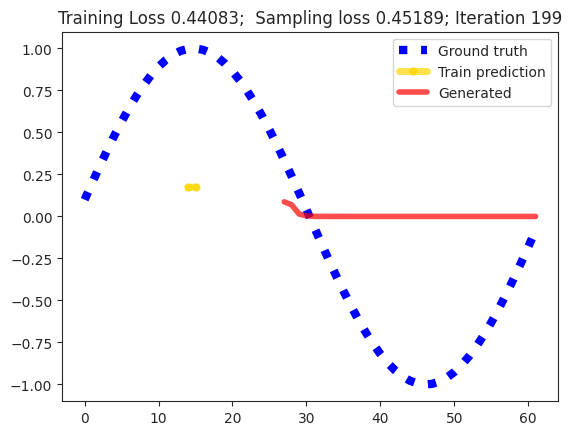

<Figure size 640x480 with 0 Axes>

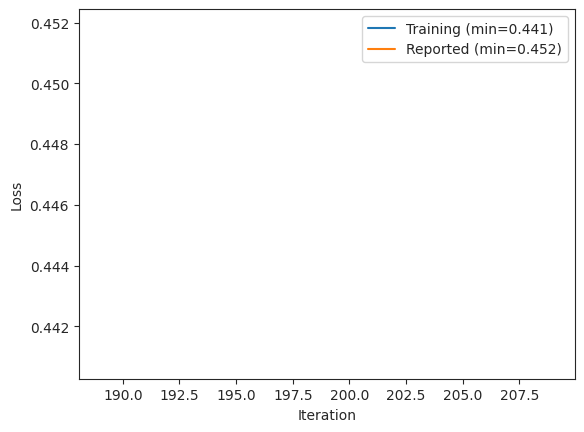

[400] avg_loss: 0.30327, report_loss: 0.43086, 


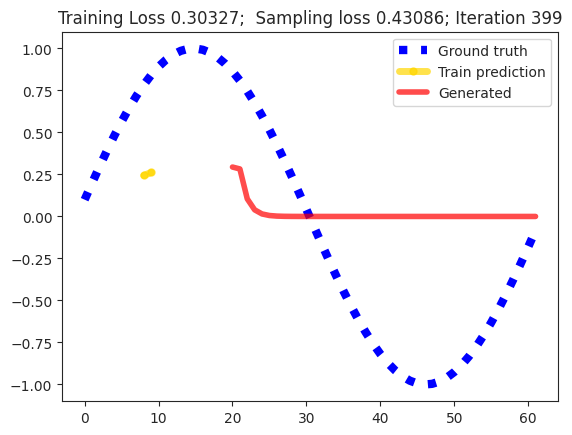

<Figure size 640x480 with 0 Axes>

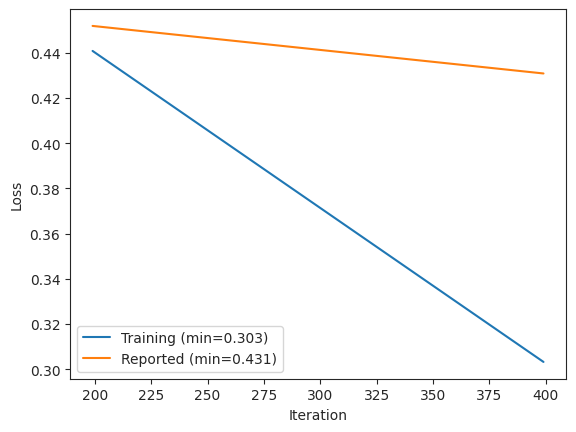

[600] avg_loss: 0.20304, report_loss: 0.54974, 


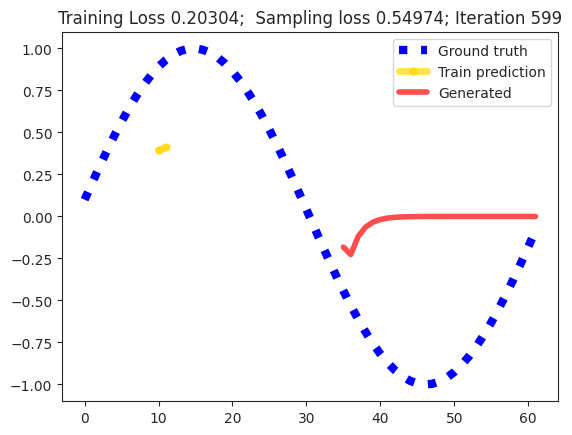

<Figure size 640x480 with 0 Axes>

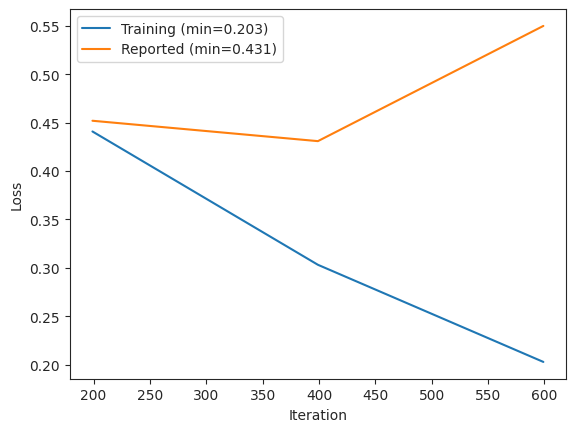

[800] avg_loss: 0.11384, report_loss: 0.41840, 


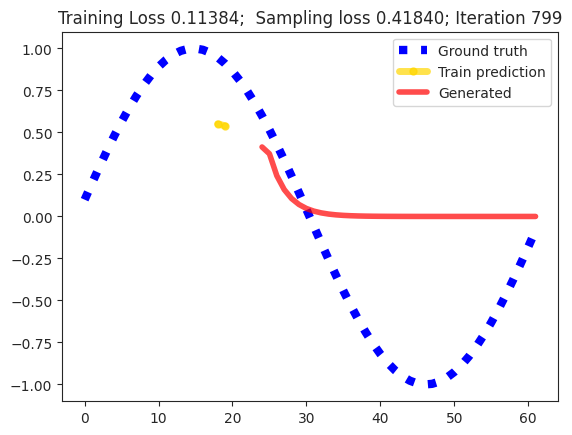

<Figure size 640x480 with 0 Axes>

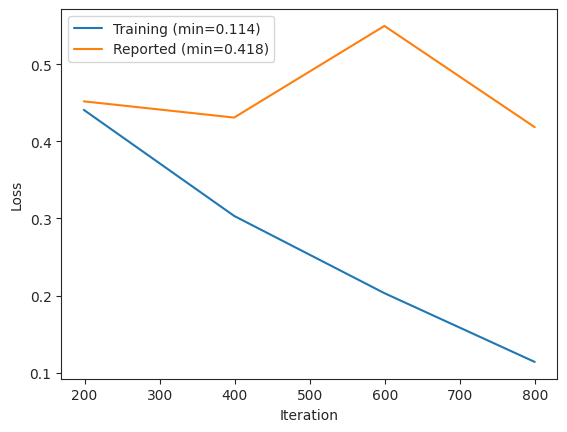

[1000] avg_loss: 0.07335, report_loss: 0.29949, 


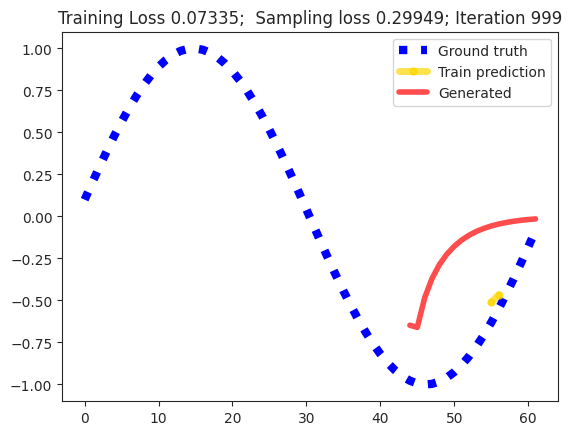

<Figure size 640x480 with 0 Axes>

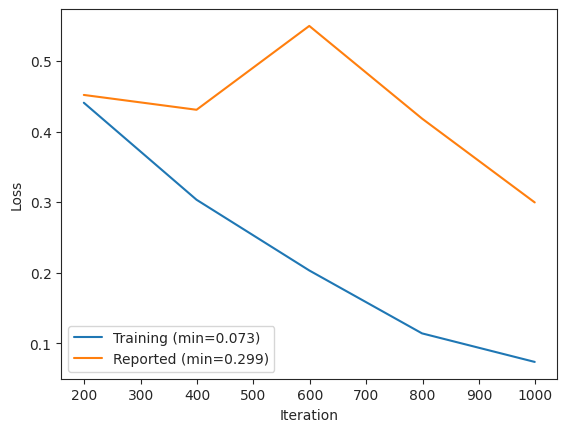

[1200] avg_loss: 0.03801, report_loss: 0.45608, 


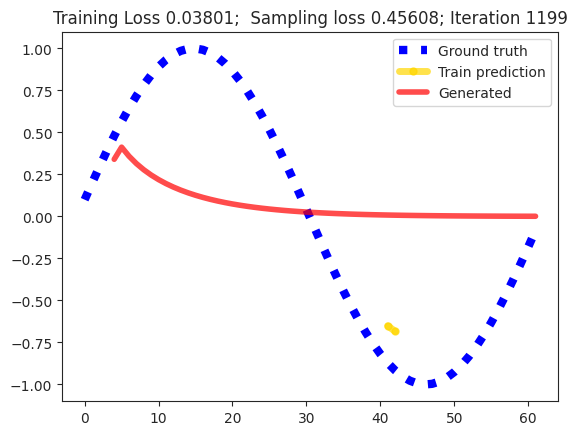

<Figure size 640x480 with 0 Axes>

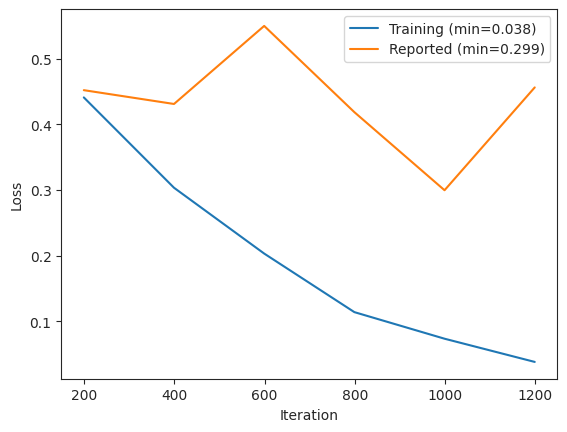

[1400] avg_loss: 0.02018, report_loss: 0.53155, 


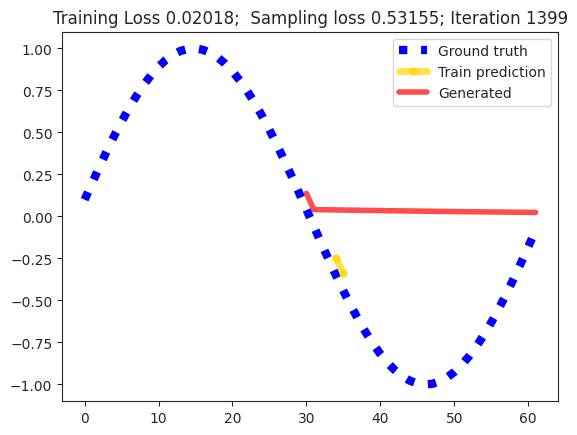

<Figure size 640x480 with 0 Axes>

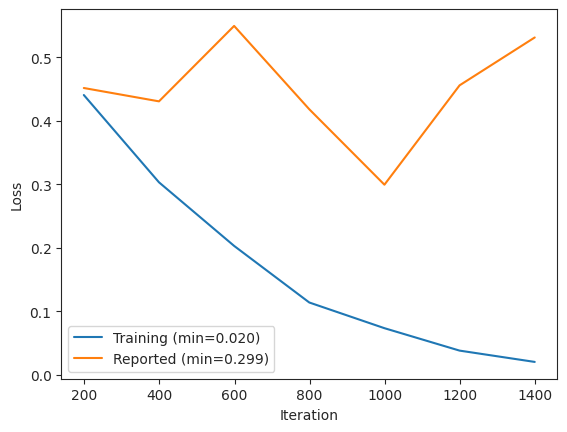

[1600] avg_loss: 0.01185, report_loss: 0.82891, 


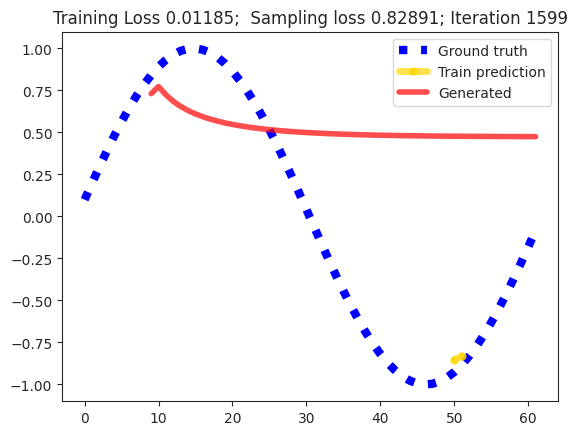

<Figure size 640x480 with 0 Axes>

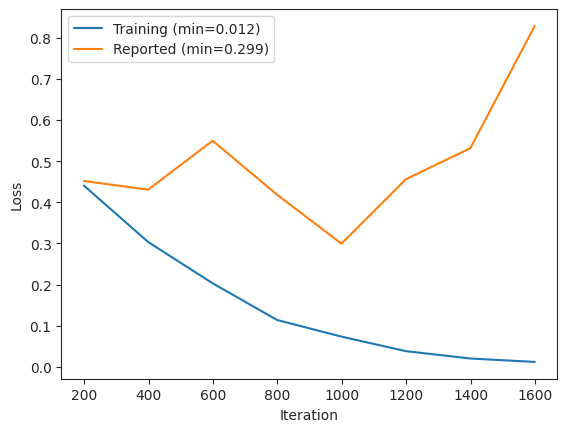

[1800] avg_loss: 0.00730, report_loss: 0.06417, 


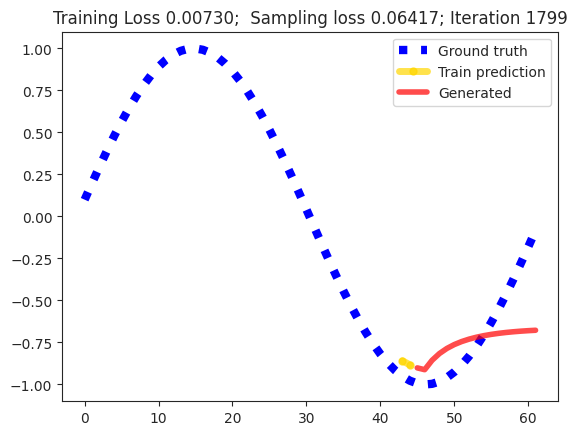

<Figure size 640x480 with 0 Axes>

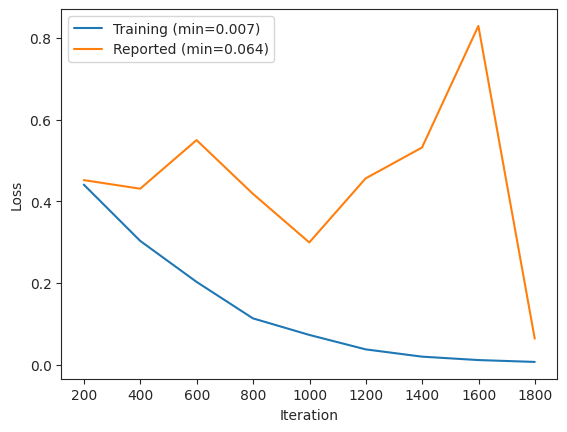

[2000] avg_loss: 0.00629, report_loss: 1.44625, 


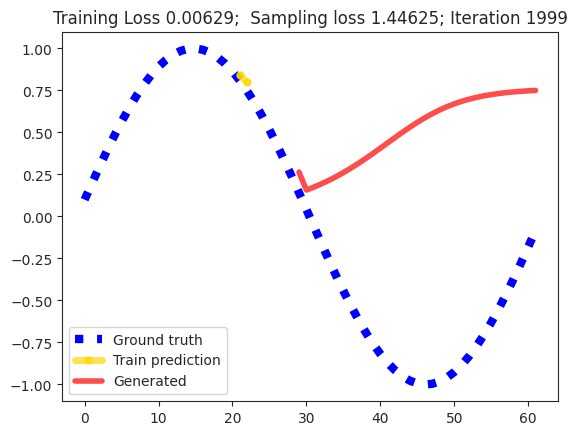

<Figure size 640x480 with 0 Axes>

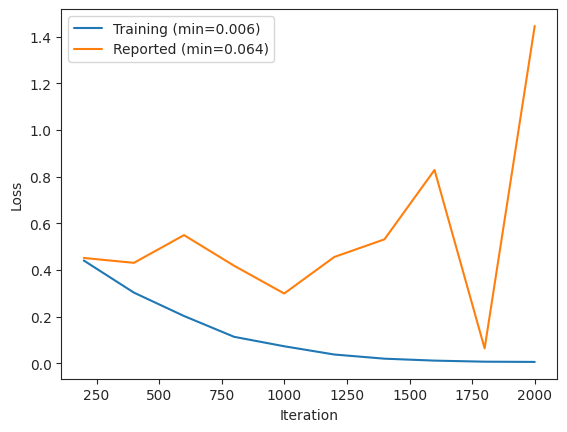

[2200] avg_loss: 0.00588, report_loss: 1.36050, 


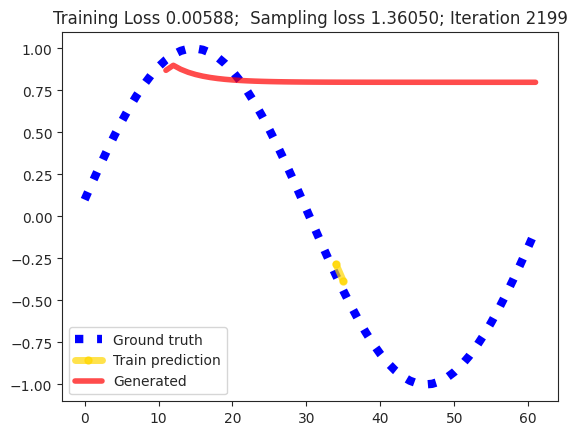

<Figure size 640x480 with 0 Axes>

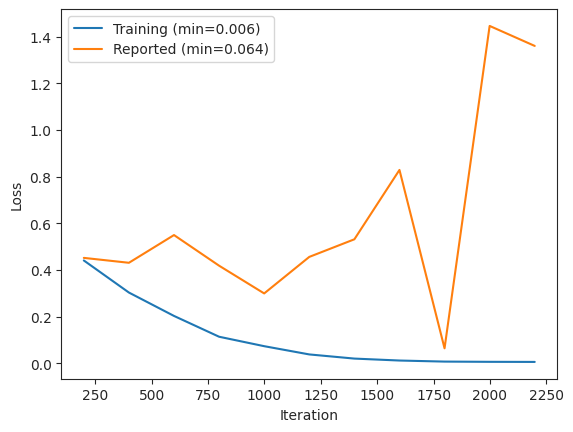

[2400] avg_loss: 0.00540, report_loss: 1.29255, 


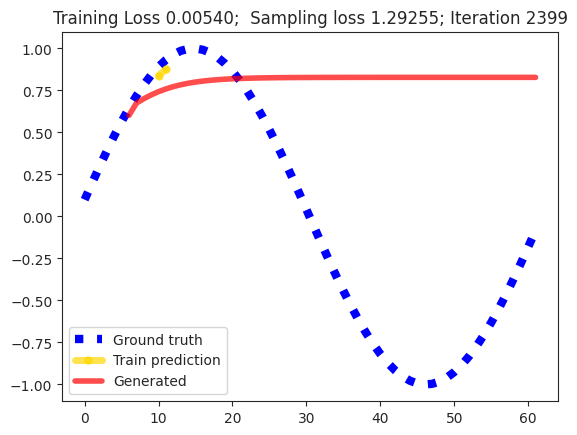

<Figure size 640x480 with 0 Axes>

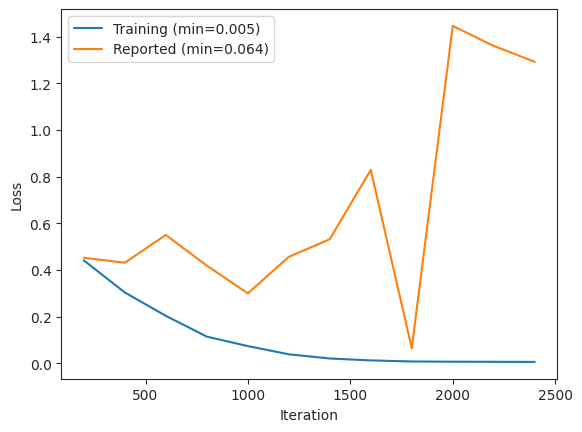

[2600] avg_loss: 0.00559, report_loss: 0.11028, 


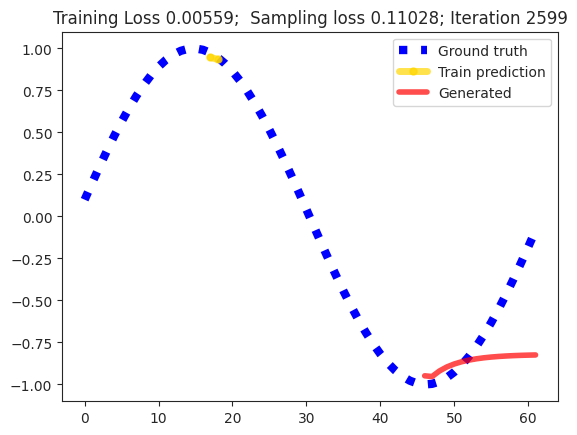

<Figure size 640x480 with 0 Axes>

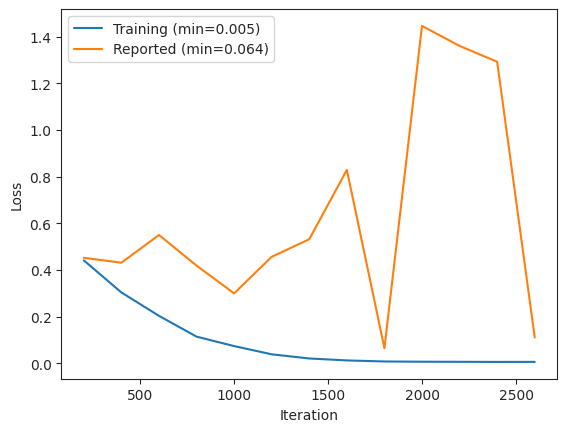

[2800] avg_loss: 0.00606, report_loss: 1.19587, 


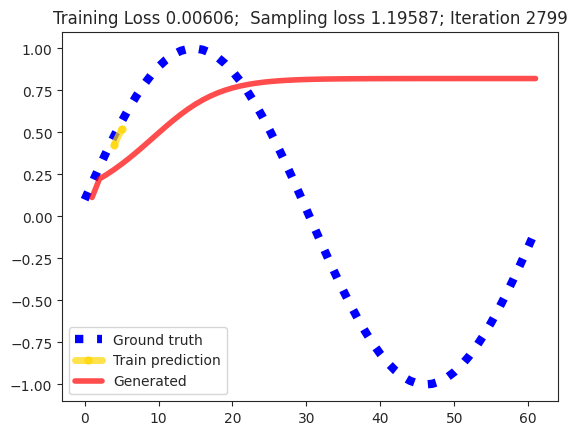

<Figure size 640x480 with 0 Axes>

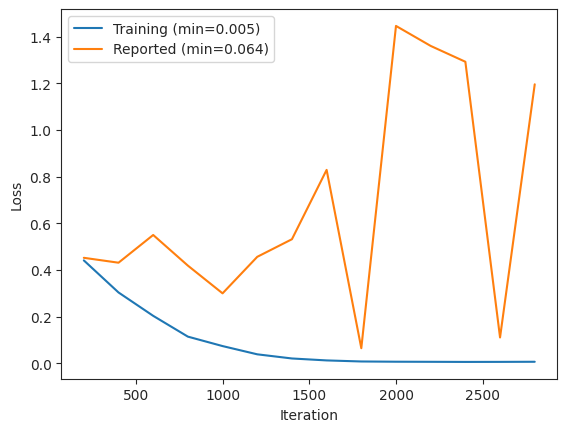

[3000] avg_loss: 0.00550, report_loss: 0.08049, 


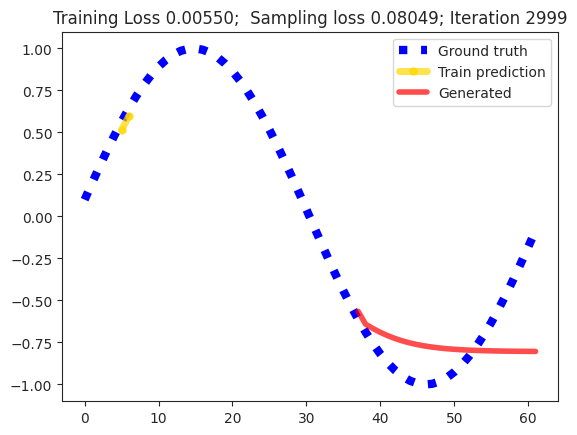

<Figure size 640x480 with 0 Axes>

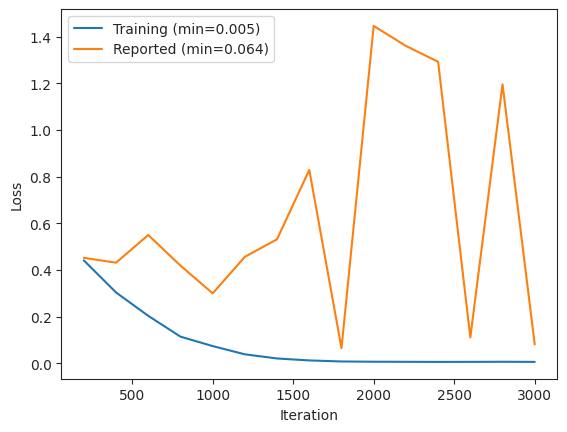

[3200] avg_loss: 0.00533, report_loss: 1.84183, 


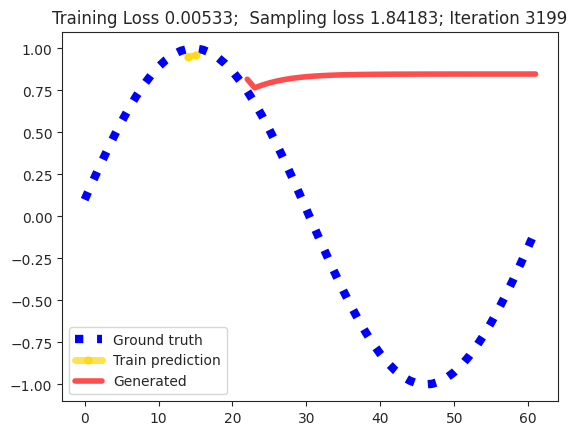

<Figure size 640x480 with 0 Axes>

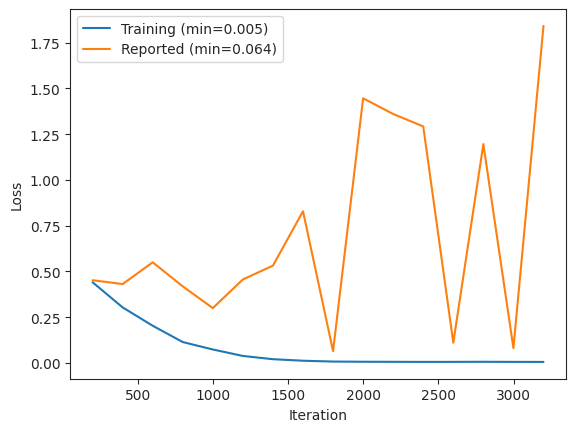

[3400] avg_loss: 0.00555, report_loss: 1.64465, 


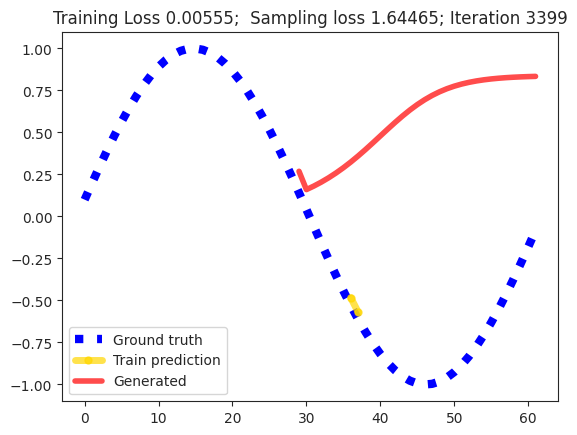

<Figure size 640x480 with 0 Axes>

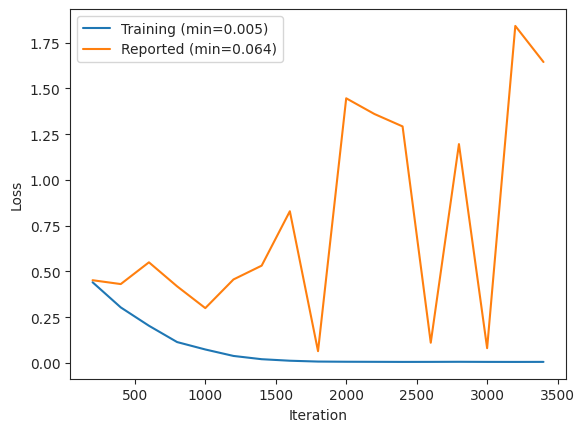

[3600] avg_loss: 0.00556, report_loss: 1.80634, 


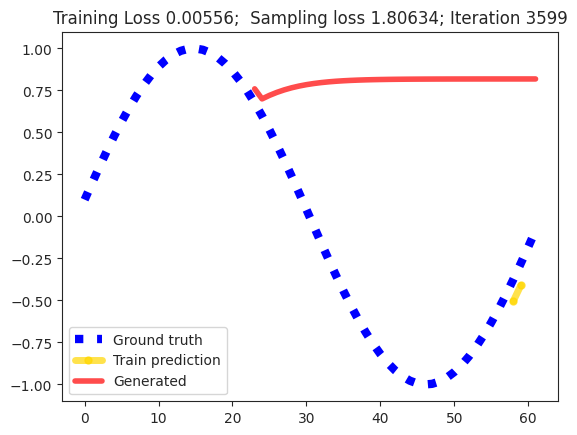

<Figure size 640x480 with 0 Axes>

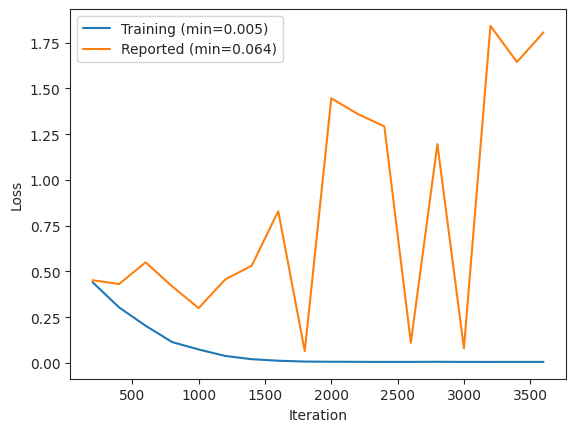

[3800] avg_loss: 0.00561, report_loss: 1.74832, 


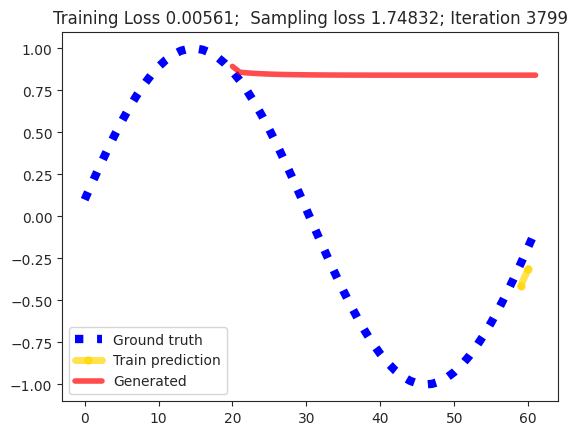

<Figure size 640x480 with 0 Axes>

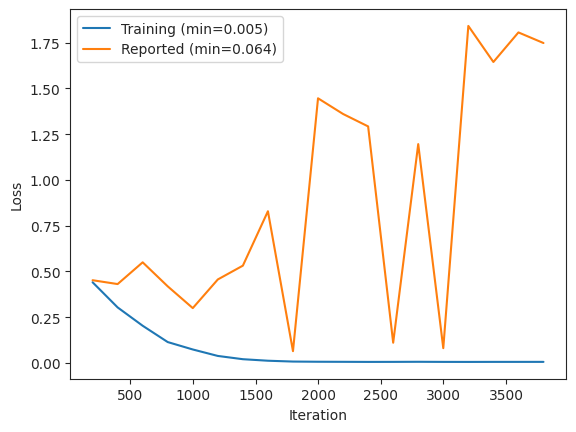

[4000] avg_loss: 0.00584, report_loss: 1.17992, 


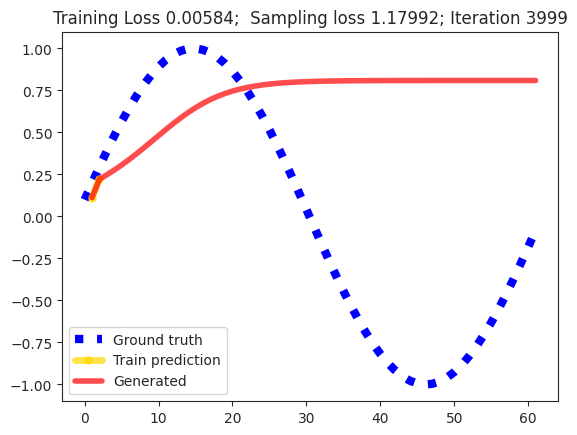

<Figure size 640x480 with 0 Axes>

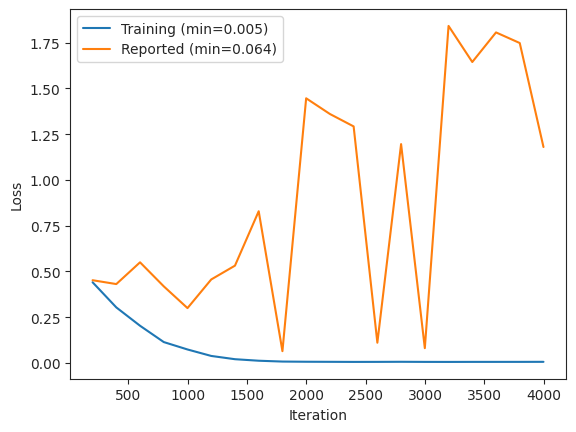

[4200] avg_loss: 0.00608, report_loss: 0.10704, 


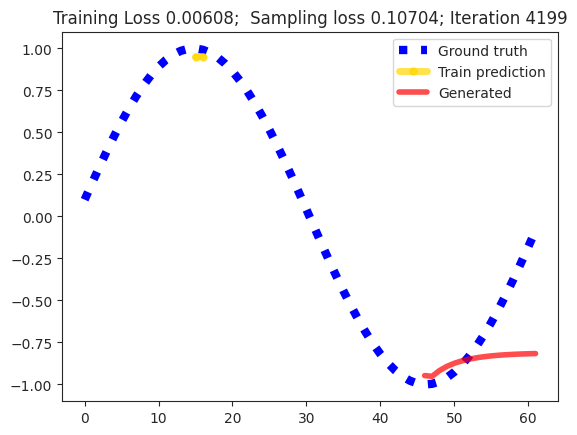

<Figure size 640x480 with 0 Axes>

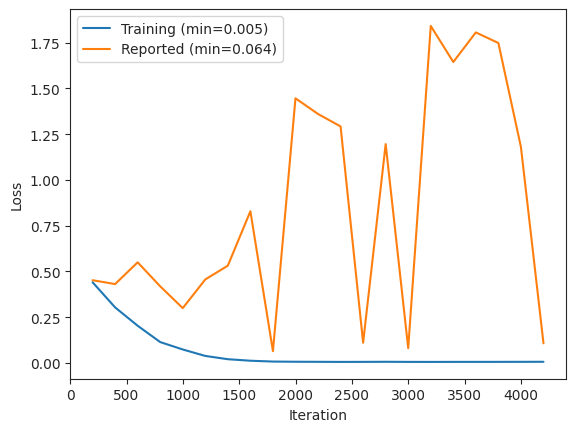

[4400] avg_loss: 0.00510, report_loss: 1.23085, 


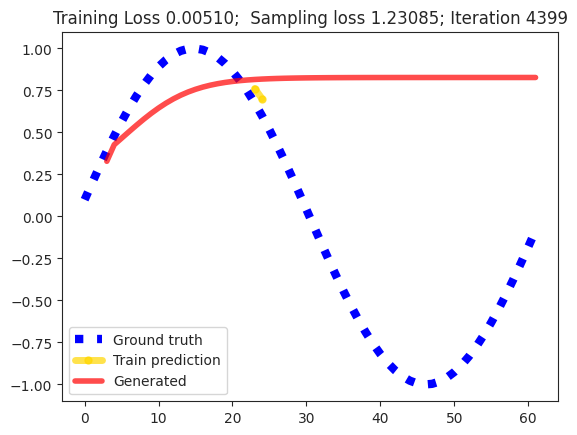

<Figure size 640x480 with 0 Axes>

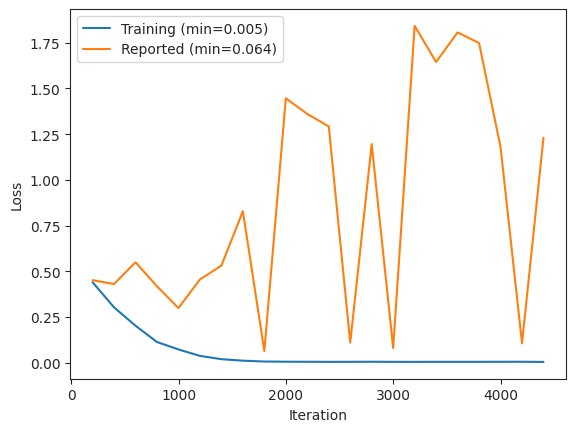

[4600] avg_loss: 0.00504, report_loss: 0.10020, 


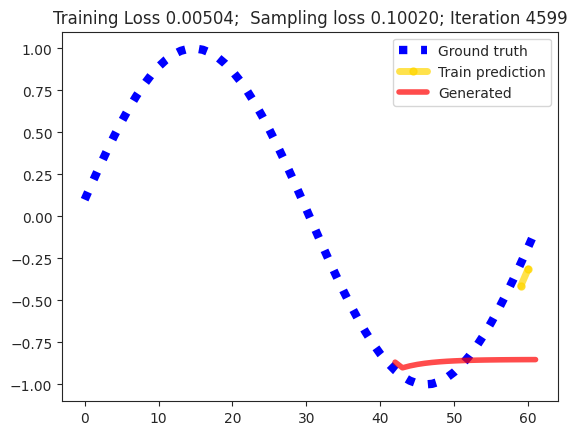

<Figure size 640x480 with 0 Axes>

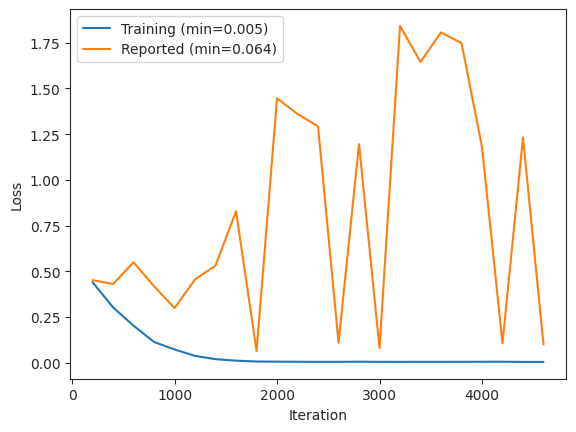

[4800] avg_loss: 0.00570, report_loss: 0.09314, 


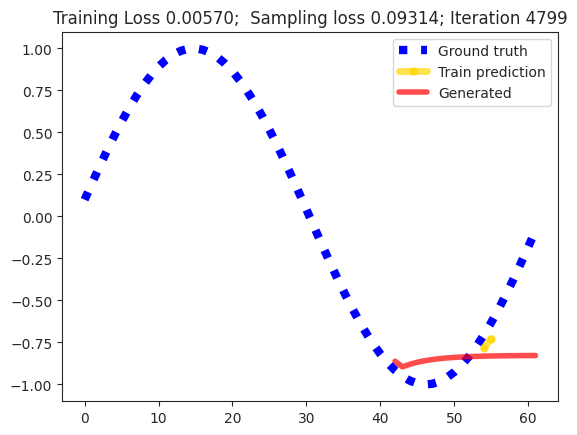

<Figure size 640x480 with 0 Axes>

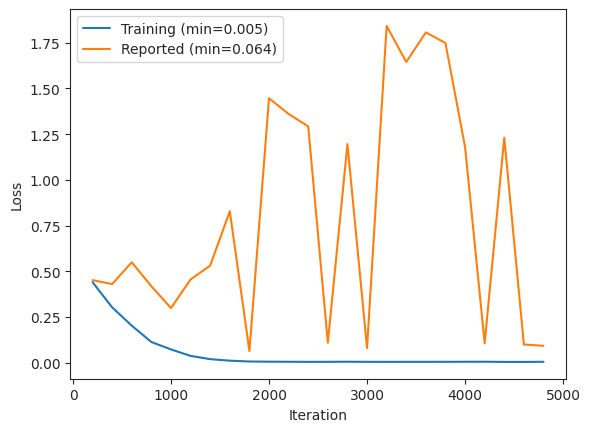

[5000] avg_loss: 0.00511, report_loss: 1.71762, 


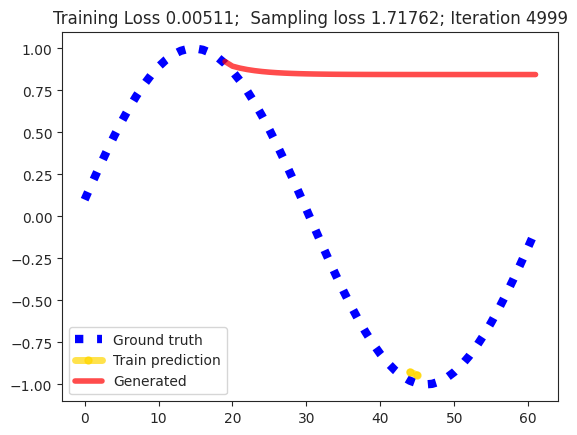

<Figure size 640x480 with 0 Axes>

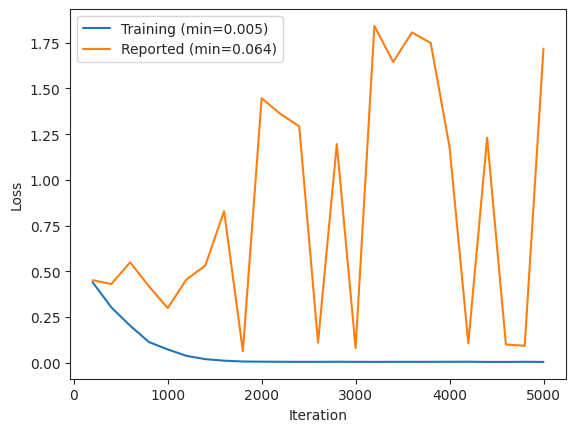

[5200] avg_loss: 0.00485, report_loss: 1.50814, 


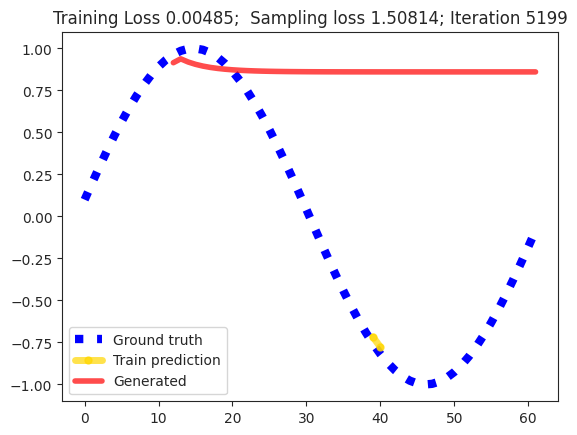

<Figure size 640x480 with 0 Axes>

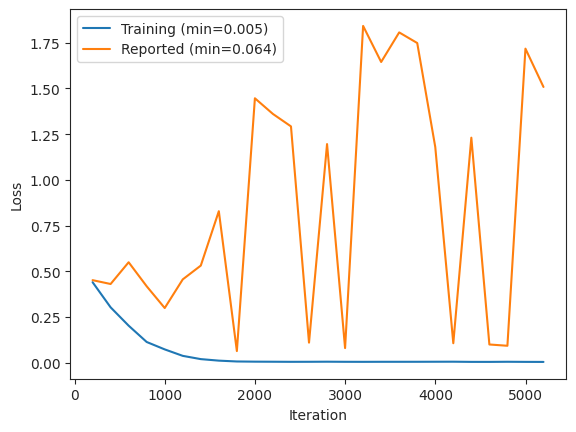

[5400] avg_loss: 0.00516, report_loss: 1.14165, 


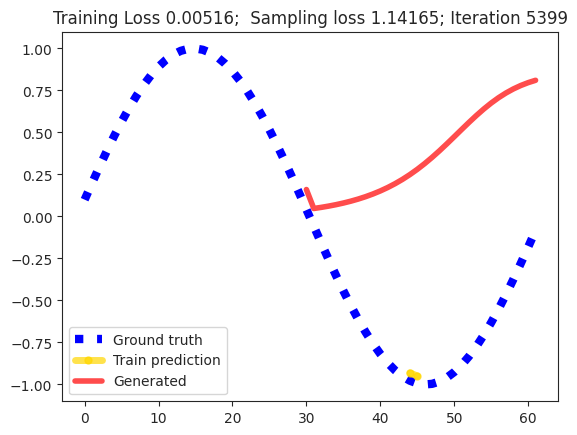

<Figure size 640x480 with 0 Axes>

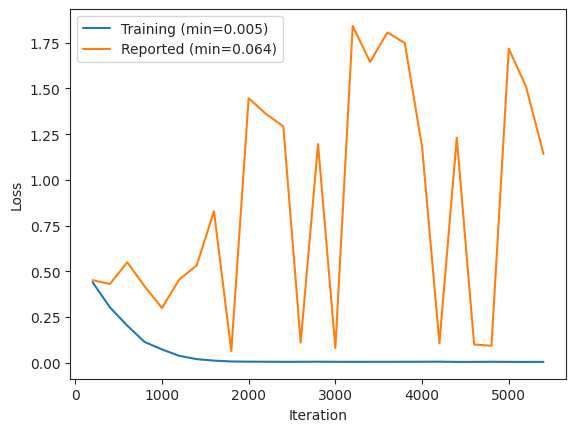

[5600] avg_loss: 0.00619, report_loss: 1.74409, 


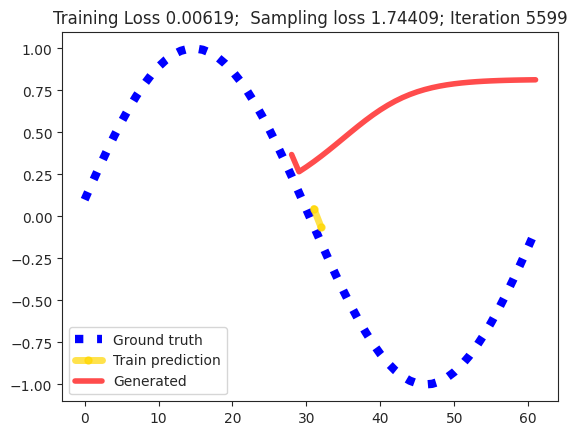

<Figure size 640x480 with 0 Axes>

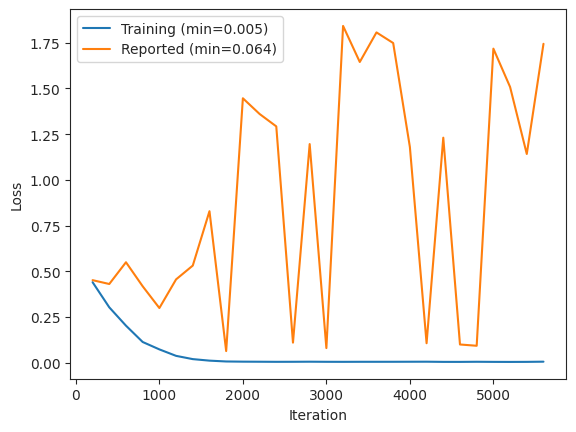

[5800] avg_loss: 0.00606, report_loss: 1.78781, 


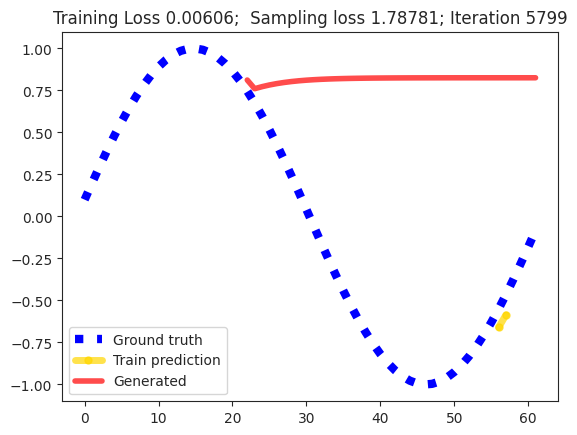

<Figure size 640x480 with 0 Axes>

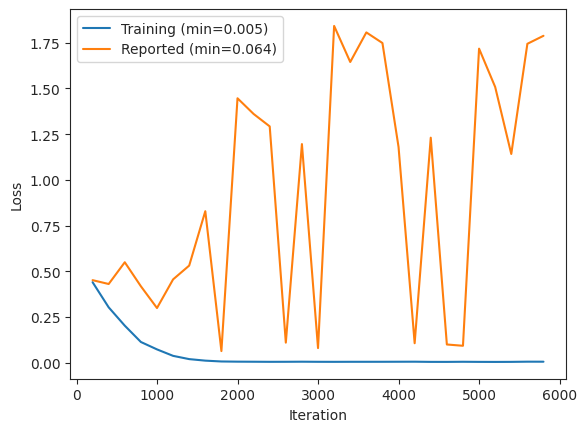

[6000] avg_loss: 0.00499, report_loss: 1.67277, 


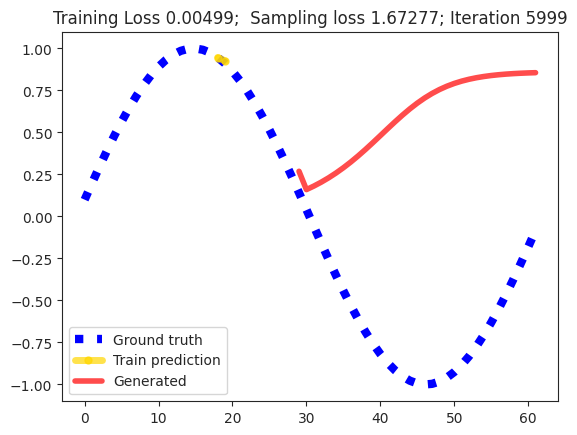

<Figure size 640x480 with 0 Axes>

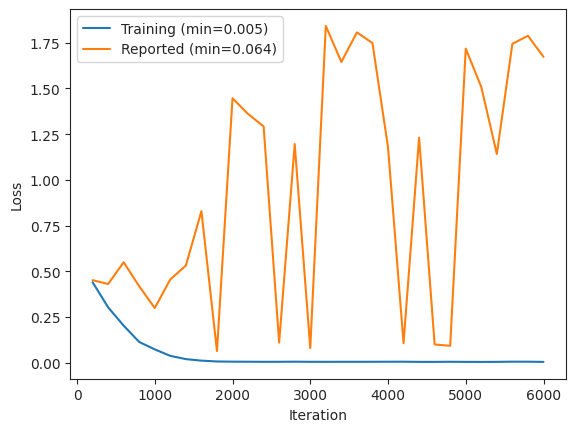

[6200] avg_loss: 0.00525, report_loss: 1.93564, 


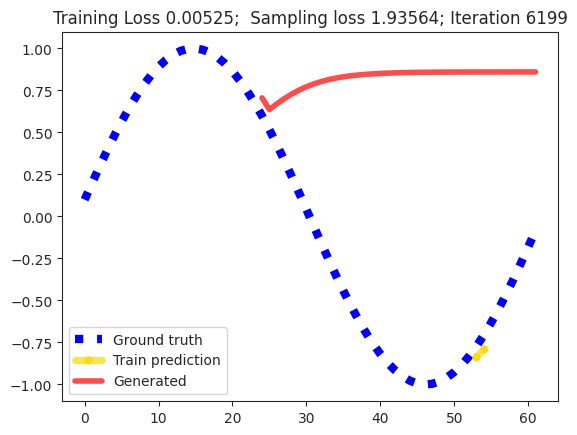

<Figure size 640x480 with 0 Axes>

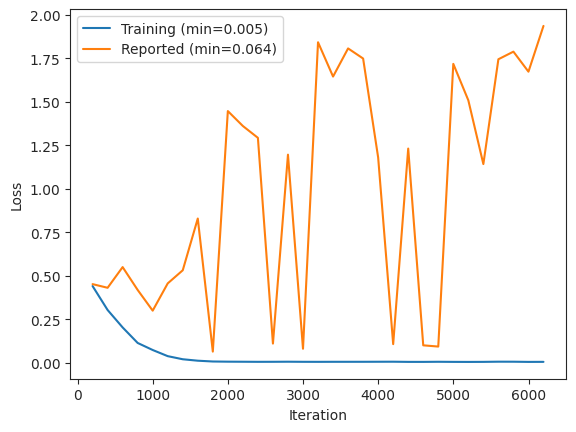

[6400] avg_loss: 0.00578, report_loss: 0.13952, 


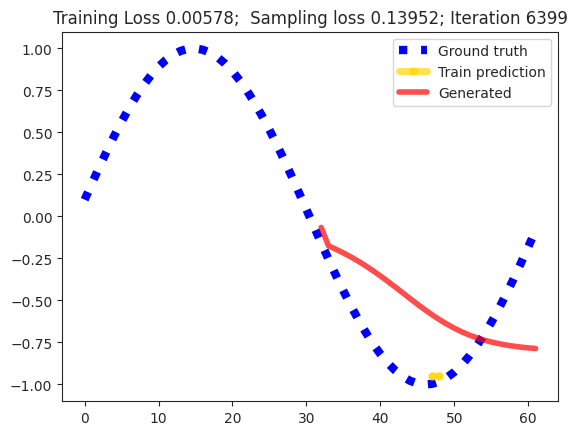

<Figure size 640x480 with 0 Axes>

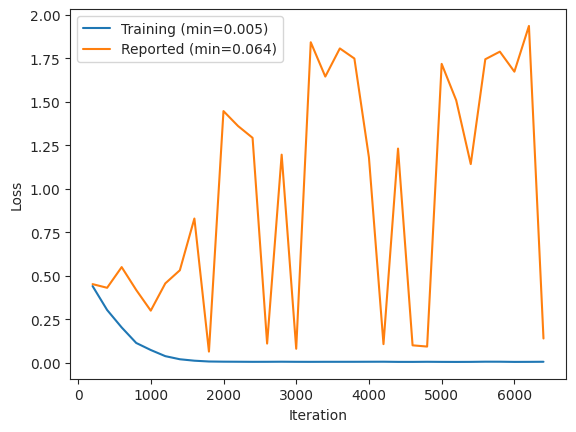

[6600] avg_loss: 0.00572, report_loss: 1.65945, 


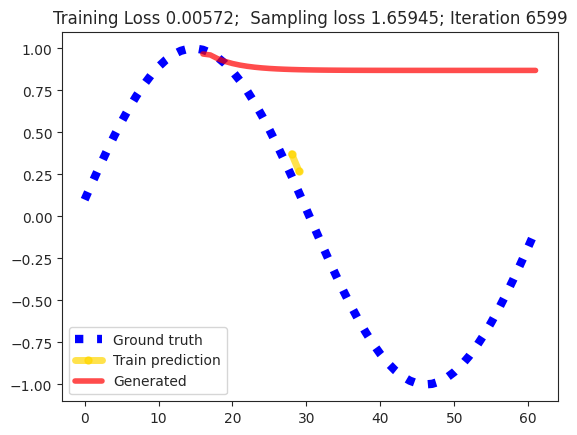

<Figure size 640x480 with 0 Axes>

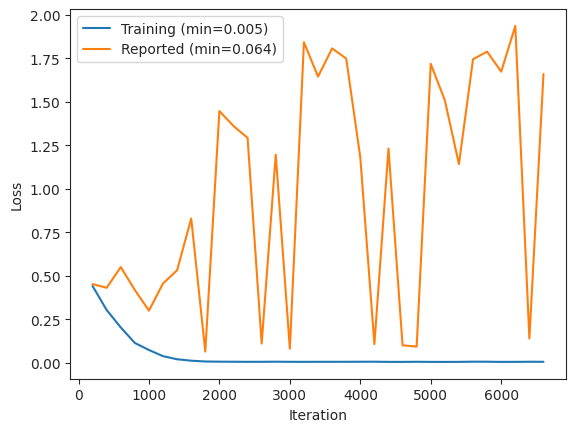

[6800] avg_loss: 0.00503, report_loss: 1.37854, 


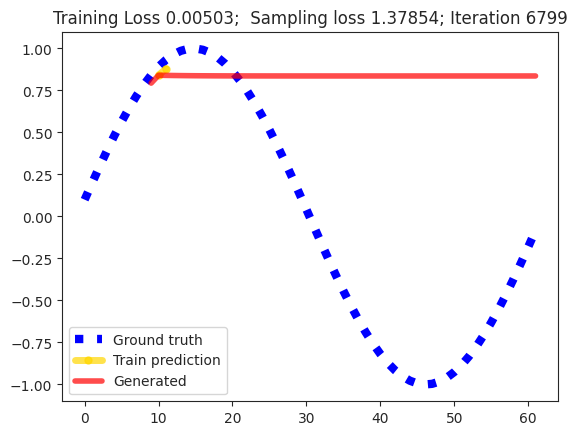

<Figure size 640x480 with 0 Axes>

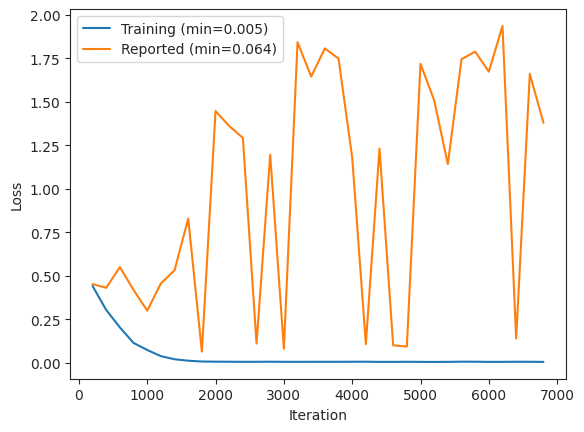

[7000] avg_loss: 0.00547, report_loss: 1.20219, 


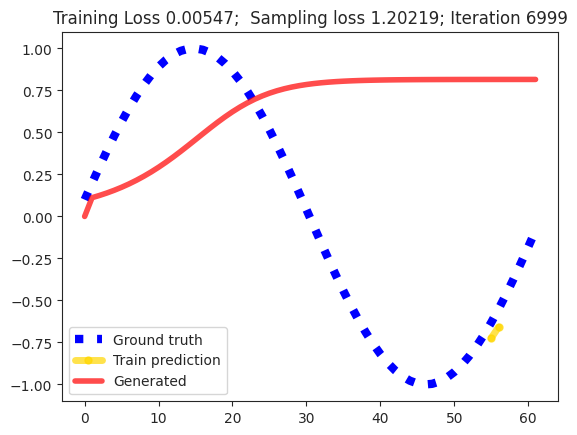

<Figure size 640x480 with 0 Axes>

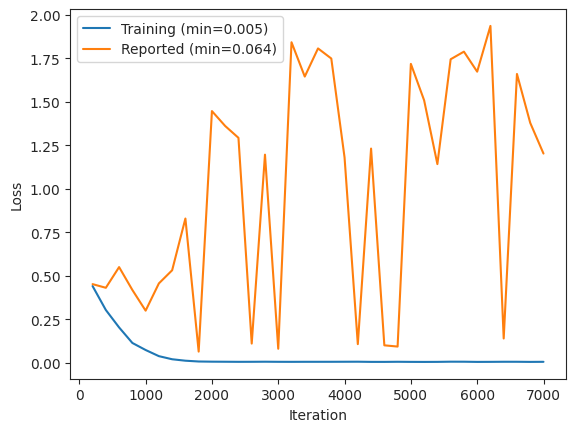

[7200] avg_loss: 0.00553, report_loss: 0.08703, 


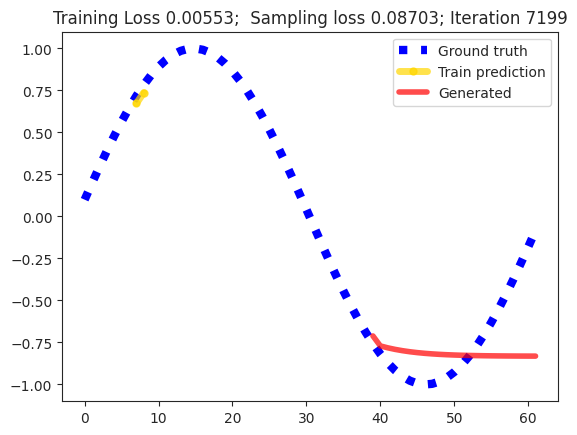

<Figure size 640x480 with 0 Axes>

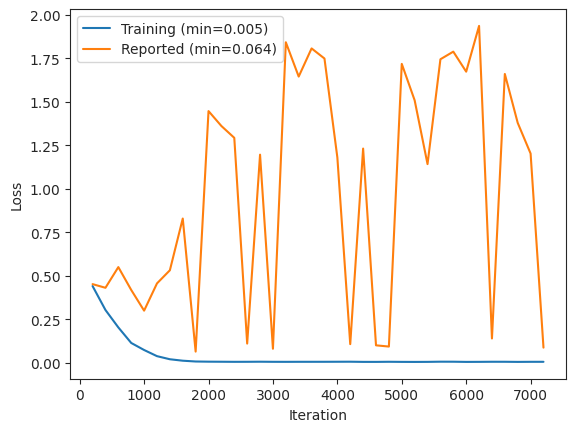

[7400] avg_loss: 0.00503, report_loss: 1.66177, 


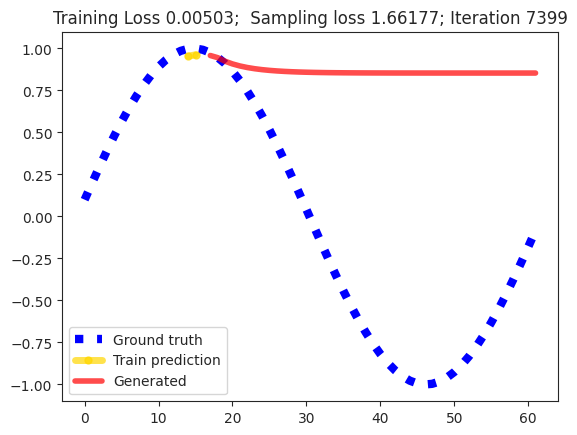

<Figure size 640x480 with 0 Axes>

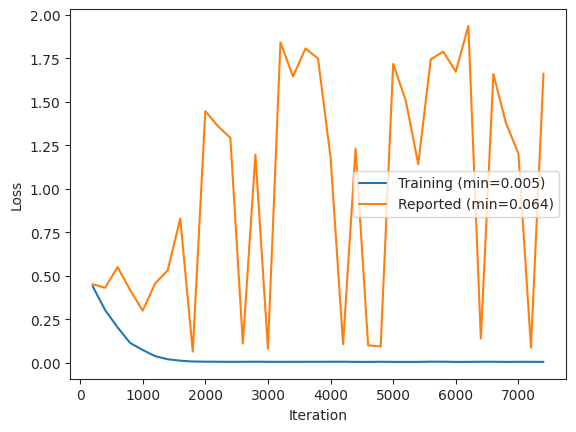

[7600] avg_loss: 0.00479, report_loss: 1.99230, 


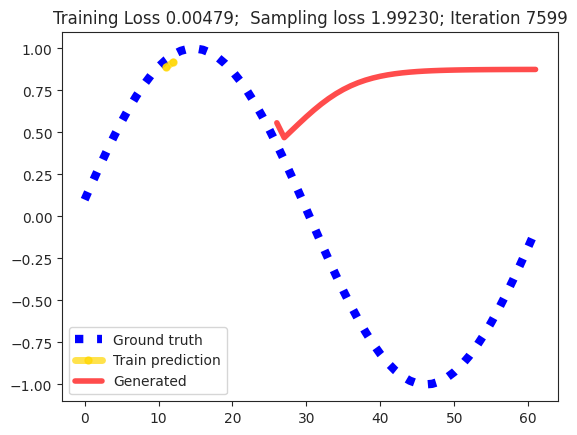

<Figure size 640x480 with 0 Axes>

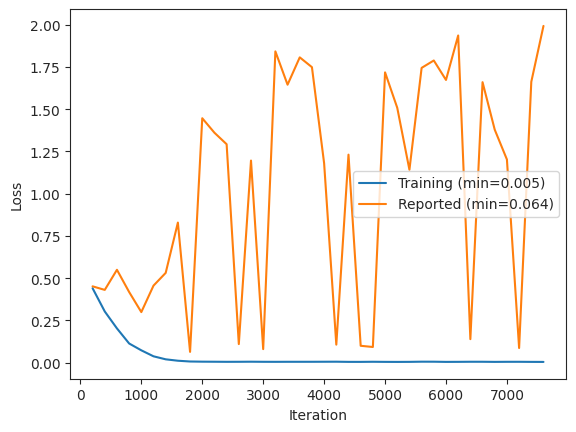

[7800] avg_loss: 0.00496, report_loss: 1.36853, 


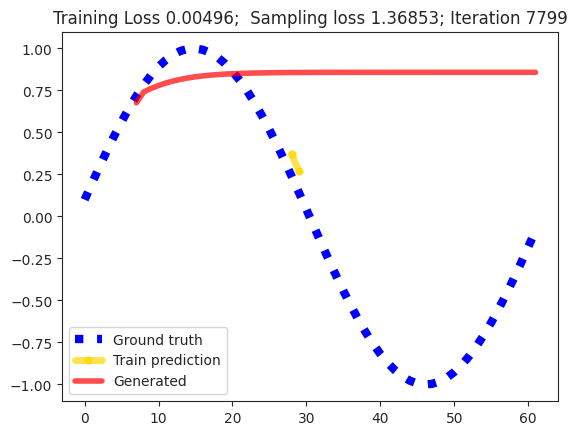

<Figure size 640x480 with 0 Axes>

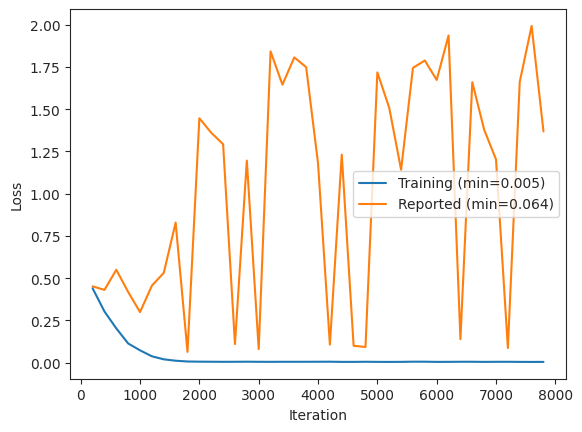

[8000] avg_loss: 0.00535, report_loss: 1.75802, 


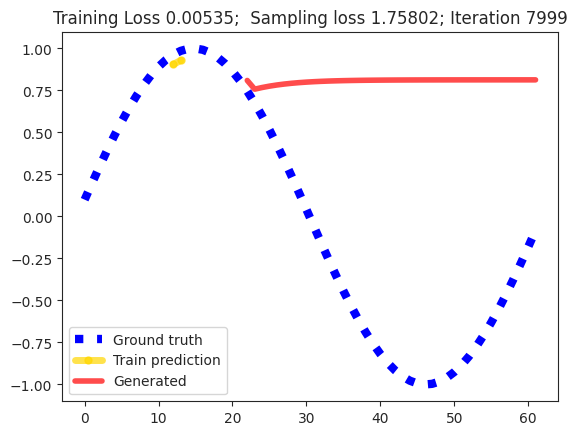

<Figure size 640x480 with 0 Axes>

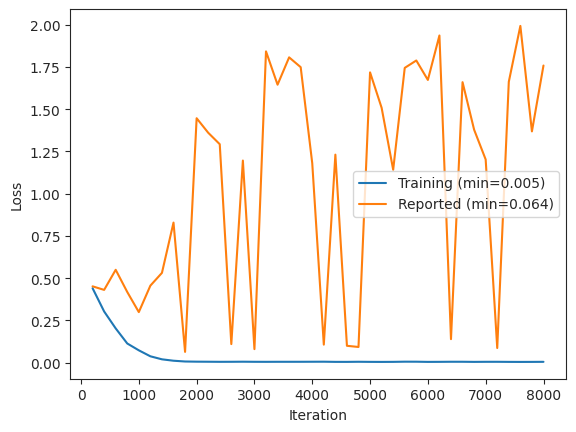

[8200] avg_loss: 0.00560, report_loss: 1.79310, 


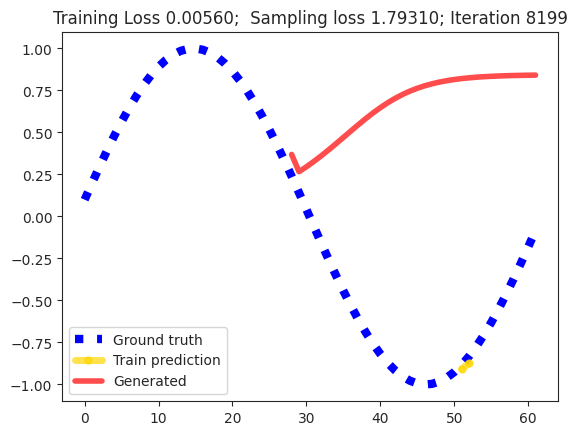

<Figure size 640x480 with 0 Axes>

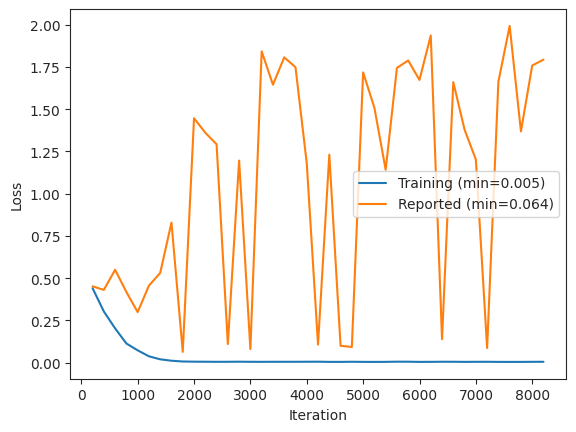

[8400] avg_loss: 0.00565, report_loss: 0.08887, 


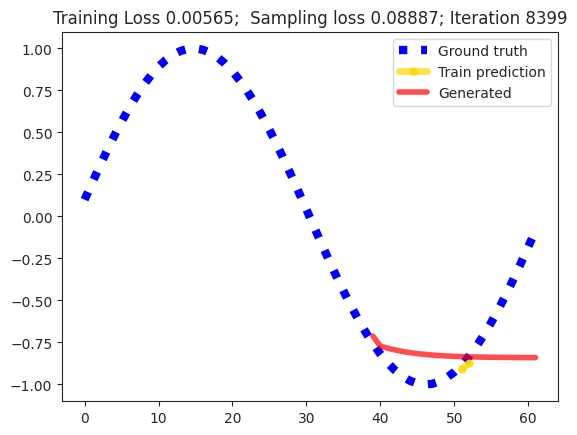

<Figure size 640x480 with 0 Axes>

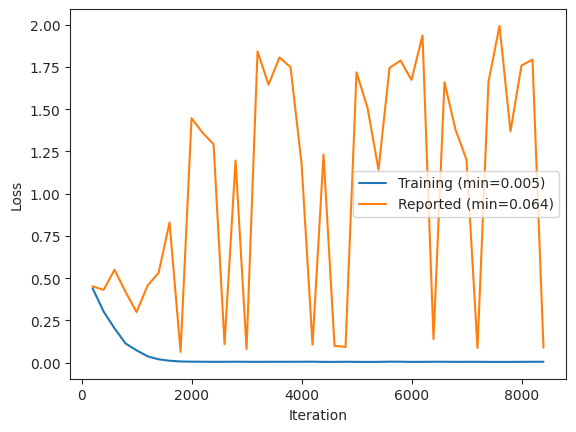

[8600] avg_loss: 0.00559, report_loss: 0.08008, 


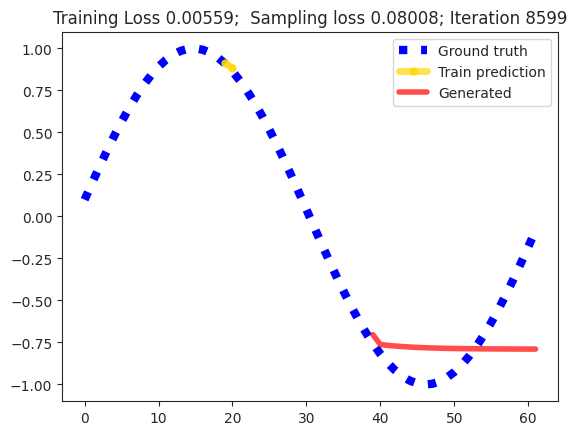

<Figure size 640x480 with 0 Axes>

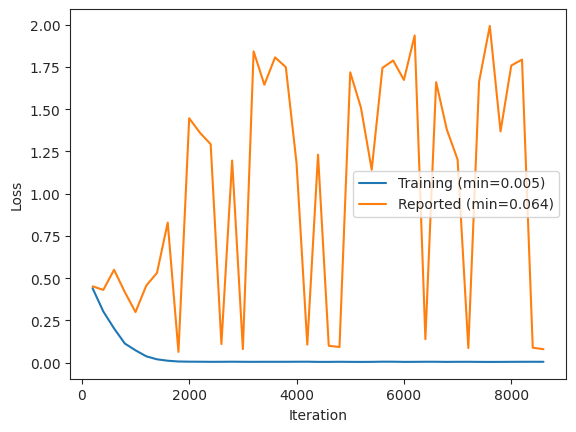

[8800] avg_loss: 0.00548, report_loss: 0.08127, 


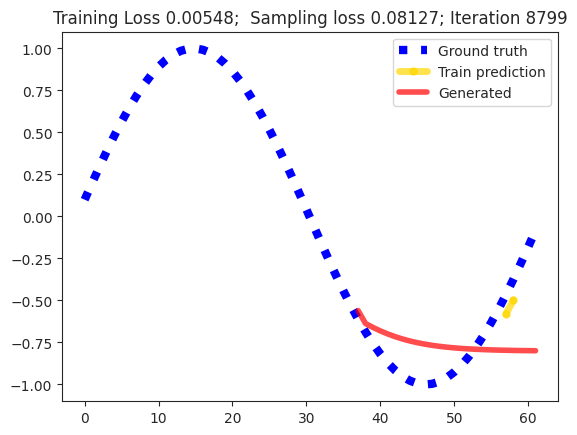

<Figure size 640x480 with 0 Axes>

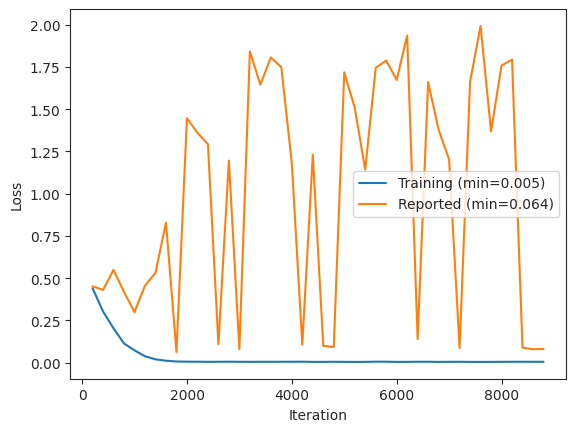

[9000] avg_loss: 0.00464, report_loss: 1.51734, 


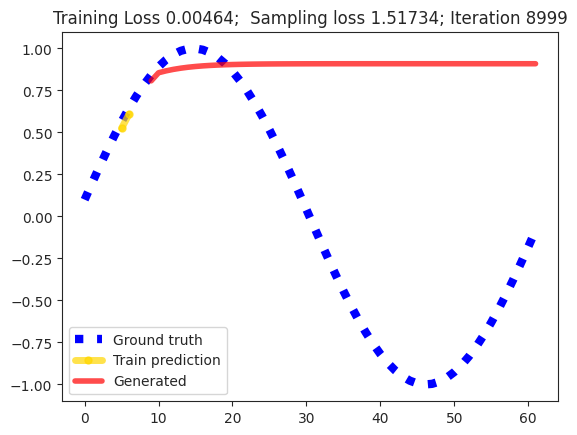

<Figure size 640x480 with 0 Axes>

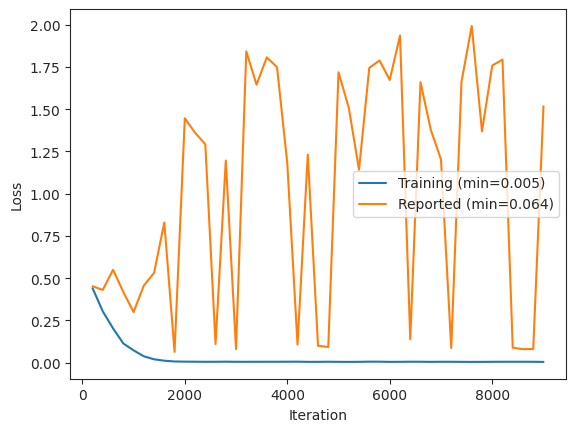

[9200] avg_loss: 0.00498, report_loss: 1.48810, 


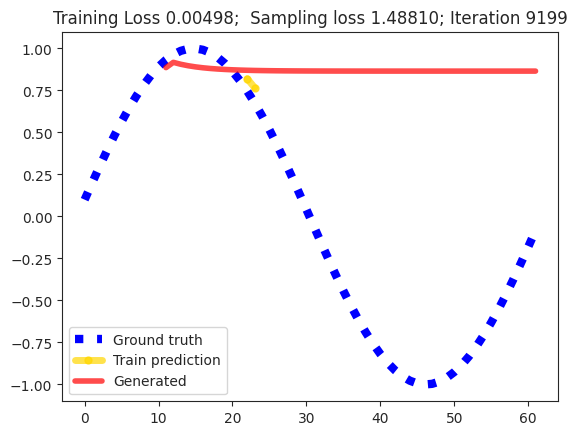

<Figure size 640x480 with 0 Axes>

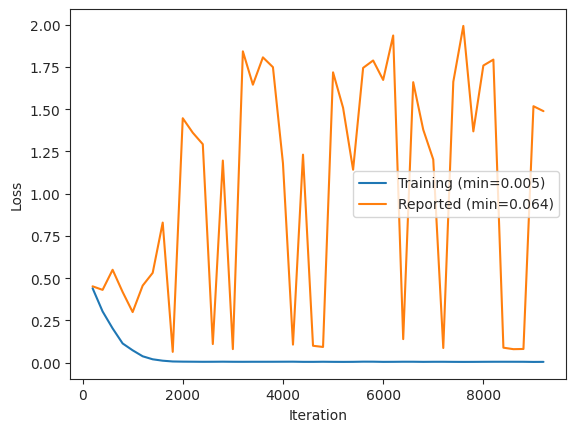

[9400] avg_loss: 0.00582, report_loss: 1.60910, 


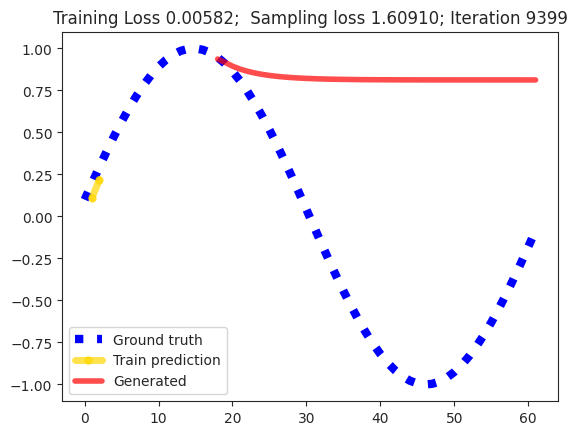

<Figure size 640x480 with 0 Axes>

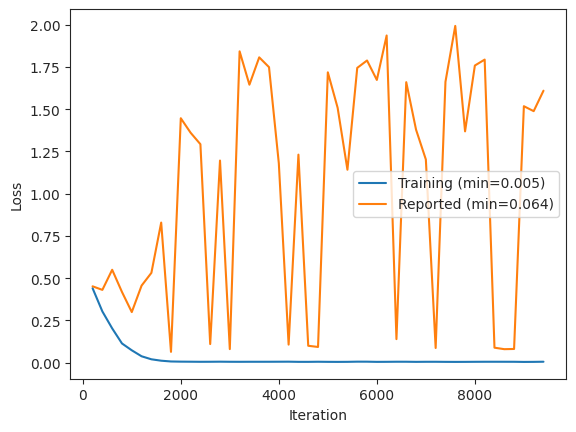

[9600] avg_loss: 0.00507, report_loss: 0.10654, 


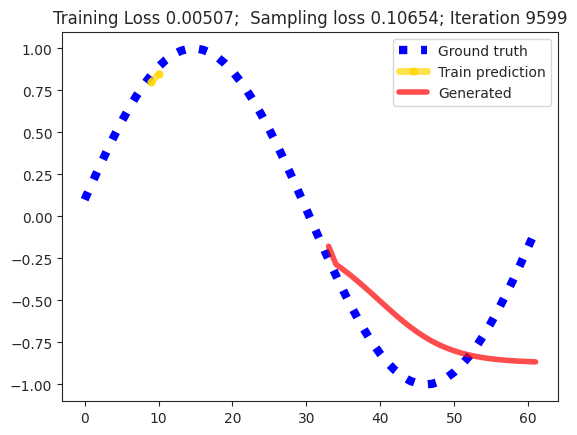

<Figure size 640x480 with 0 Axes>

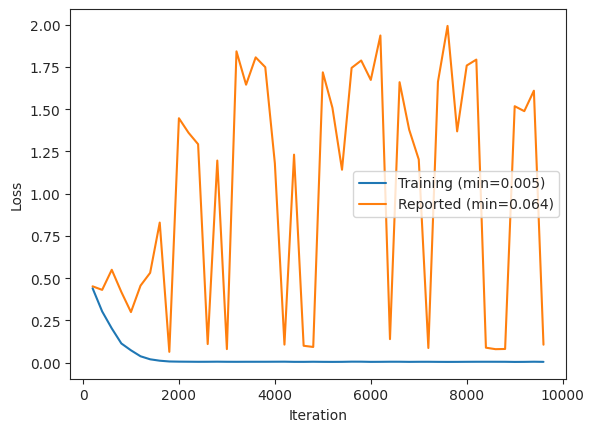

[9800] avg_loss: 0.00542, report_loss: 0.12180, 


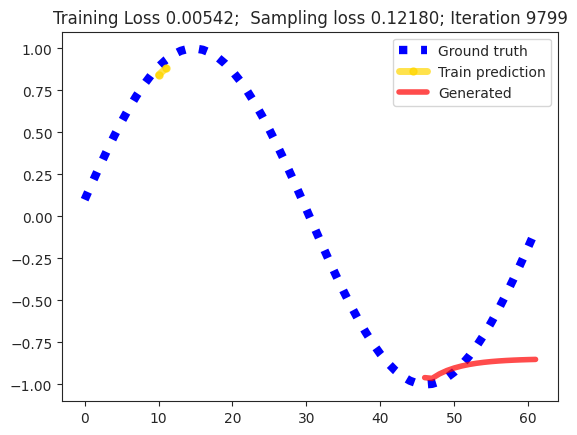

<Figure size 640x480 with 0 Axes>

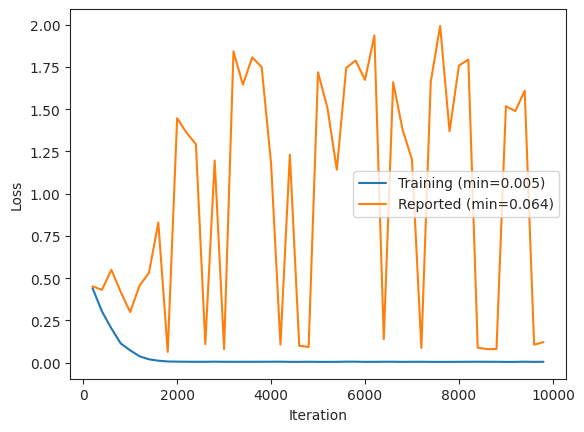

[10000] avg_loss: 0.00487, report_loss: 1.78069, 


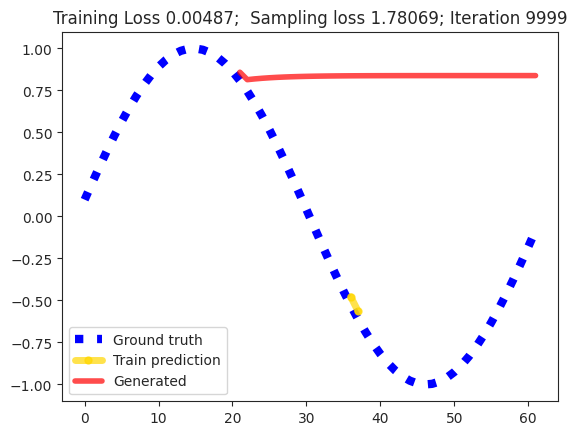

<Figure size 640x480 with 0 Axes>

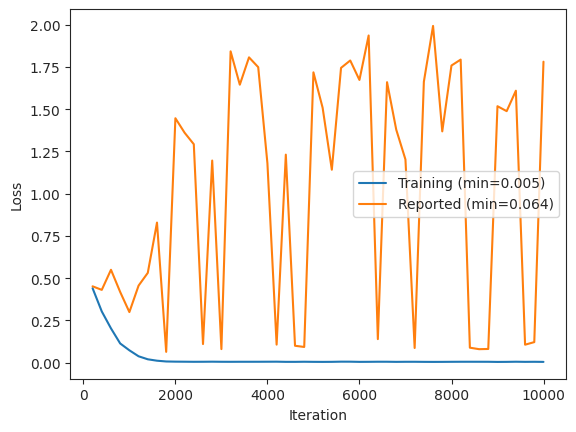

In [16]:
UNROLL_LENGTH = 3  # @param {type:"integer"}
NUM_ITERATIONS = 10000  # @param {type:"integer"}
WARM_START = 2  # @param {type:"integer"}
TEACHER_FORCING_PROB = 1  # @param {type:"number"}
HIDDEN_UNITS = 20  # @param {type:"integer"}
LEARNING_RATE = 0.0001  # @param {type:"number"}
REPORTING_INTERVAL = 200  # @param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2 * np.pi, 0.1).reshape(-1, 1, 1)
y_train = np.sin(x_train)

net = VanillaRNN(hidden_size=HIDDEN_UNITS, bias=False)
net.train()
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

running_loss = 0

history_training_loss = []
history_reported_loss = []
history_iterations = []

for iteration in range(NUM_ITERATIONS):
    # select a start point in the training set for a sequence of UNROLL_LENGTH
    start = np.random.choice(range(x_train.shape[0] - UNROLL_LENGTH))
    train_sequence = y_train[start : (start + UNROLL_LENGTH)]

    train_inputs = torch.from_numpy(train_sequence[:-1]).float().to(device)
    train_targets = torch.from_numpy(train_sequence[1:]).float().to(device)

    optimizer.zero_grad()

    outputs, hidden = net(
        train_inputs, hidden=None,
        teacher_forcing_prob=TEACHER_FORCING_PROB,
        warm_start=0    # warm start is not used during training
    )
    loss = criterion(outputs, train_targets)
    loss.backward()

    running_loss += loss.item()

    optimizer.step()

    if iteration % REPORTING_INTERVAL == REPORTING_INTERVAL - 1:
        # let's see how well we do on predictions for the whole sequence
        avg_loss = running_loss / REPORTING_INTERVAL
        # Reset the running loss, to prepare it for the next "reporting interval".
        running_loss = 0.0

        # Select a start point within the first 75% of y_train
        max_start_index = int(0.75 * len(y_train))
        start_index = np.random.choice(range(max_start_index))

        # Create the reporting sequence
        report_sequence = torch.from_numpy(y_train[start_index:-1]).float().to(device)
        report_targets = torch.from_numpy(y_train[start_index + 1:]).float().to(device)

        net.eval()
        # We are not using teacher_forcing during
        report_output, report_hidden = net(
            report_sequence, hidden=None,
            teacher_forcing_prob=0.0,  # no teacher forcing during reporting
            warm_start=WARM_START
        )
        net.train()

        report_loss = criterion(report_output, report_targets)
        print(
            "[%d] avg_loss: %.5f, report_loss: %.5f, "
            % (iteration + 1, avg_loss, report_loss.item())
        )

        plt.figure()
        plt.title(
            "Training Loss %.5f;  Sampling loss %.5f; Iteration %d"
            % (avg_loss, report_loss.item(), iteration)
        )

        plt.plot(
            y_train[1:].ravel(), c="blue", label="Ground truth", linestyle=":", lw=6
        )
        plt.plot(
            range(start, start + UNROLL_LENGTH - 1),
            outputs.data.cpu().numpy().ravel(),
            c="gold",
            label="Train prediction",
            lw=5,
            marker="o",
            markersize=5,
            alpha=0.7,
        )
        plt.plot(
            range(start_index, len(y_train)-1),
            report_output.data.cpu().numpy().ravel(),
            c="r",
            label="Generated",
            lw=4,
            alpha=0.7,
        )
        plt.legend()
        plt.show()

        history_training_loss.append(avg_loss)
        history_reported_loss.append(report_loss.item())
        history_iterations.append(iteration)
        # Try to steal the dimensions from the previous figure.
        plt.figure(figsize=plt.gcf().get_size_inches())  # type: ignore
        plt.plot(
            history_iterations,
            history_training_loss,
            label=f"Training (min={min(history_training_loss):.3f})",
        )
        plt.plot(
            history_iterations,
            history_reported_loss,
            label=f"Reported (min={min(history_reported_loss):.3f})",
        )
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

**Note:** initialization is not fixed (we do not fix a random seed), so each time the cell is executed, the parameters take new initial values and hence training can lead to different results. What happens if you run it multiple times?

### What is worth trying/understanding here?

* Difference between teacher forcing and learning on own samples:
 * What are the pros and cons of teacher forcing?
* In which setup (combination of unroll_length and teacher forcing probability) is the model struggling to learn?
* How does warm starting affect test time prediction? Why?
* What happens if the structure of interest is much longer than the unroll length?